In [1]:
import os
import sys
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np

path_to_this_notebook = os.path.abspath('../')
path_to_project = path_to_this_notebook[:path_to_this_notebook.find('note')]
sys.path.append(path_to_project)

%load_ext autoreload
%autoreload 2

In [2]:
from src.td3_code.agents.td3 import TD3Agent
from src.td3_code.memory.trajectory_replay_buffer import TrajectoryMemoryBuffer
from src.td3_code.memory.transition_replay_buffer import TransitionMemoryBuffer
from src.td3_code.runners.runner import Runner

USING DEVICE cpu


In [7]:
import numpy as np 
import gym

env = gym.make("Pendulum-v1")

In [8]:
env.action_space, env.observation_space

(Box([-2.], [2.], (1,), float32),
 Box([-1. -1. -8.], [1. 1. 8.], (3,), float32))

In [9]:
observation_dim = env.observation_space.shape[0]
action_dim =  env.action_space.shape[0]
max_action_value = env.action_space.high[0]
scheme = {'observations': env.observation_space.shape, 
          'observations_next': env.observation_space.shape,
          'actions': env.action_space.shape,
          'done': (1, ), 'reward': (1, ), 'reset_mask': (1, )}

### Normal transitions

In [10]:
memory_trans = TransitionMemoryBuffer(scheme=scheme, max_size=int(1e6), min_size_to_sample=2000, 
                                      sample_during_episode=True)

memory_traj_trans = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6/200), min_size_to_sample=10, 
                                          use_transitions=True, sample_during_episode=True)

lstm_dims_list = []
hidden_dims_list = [64, 64]

agent = TD3Agent(observation_dim, action_dim, max_action_value, lstm_dims_list, hidden_dims_list,
                 actor_lr=8e-4, critic_lr=8e-4,  discount=0.99, tau=0.005,
                 policy_noise=0.2, noise_clip=0.5, policy_update_freq=2)

runner = Runner(env, memory_trans, agent)

In [11]:
batch_size = 16
n_eps = 201
print_each = 50
test_each = 50
n_test_episodes = 10

keys_to_print = ['reward']
train_results = defaultdict(list)
test_results = defaultdict(list)

for ep in range(1, n_eps):
    episode_results = runner.run(train=True, save_to_memory=True, train_bath_size=batch_size)

    for key, val in episode_results.items():
        train_results[key].append(val)
    
    if ep % print_each == 0:
        print('Training episode %d    ' % ep)

        for key in keys_to_print:
            print('    %s=%.2f' % (key, np.mean(train_results[key][-print_each:])))
            
        print()
        
    if ep % test_each == 0:
        current_test_results = defaultdict(list)

        for test_ep in range(n_test_episodes):
            episode_results = runner.run(train=False, save_to_memory=False)

            for key, val in episode_results.items():
                current_test_results[key].append(val)

        current_test_results = {key: np.mean(val) for key, val in current_test_results.items()}

        for key, val in current_test_results.items():
            test_results[key].append(val)
            
        print('Test run after episode %d:' % ep)

        for key in keys_to_print:
            print('    %s=%.2f' % (key, current_test_results[key]))

        print()
        

/Users/douwe/Projects/temp/RL-EVCP/src/td3_code/runners/runner.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)


Training episode 50    
    reward=-1158.44

Test run after episode 50:
    reward=-799.87

Training episode 100    
    reward=-797.70

Test run after episode 100:
    reward=-676.61

Training episode 150    
    reward=-313.29

Test run after episode 150:
    reward=-181.01

Training episode 200    
    reward=-175.42

Test run after episode 200:
    reward=-184.23



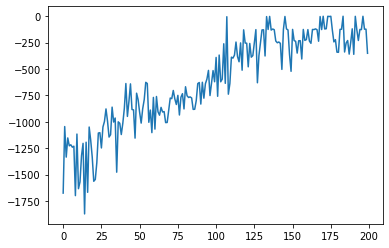

In [12]:
plt.plot(train_results['reward'])

### Transitions from the Traj buffer

In [13]:
memory_traj_trans = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6/200), min_size_to_sample=10, 
                                          use_transitions=True, sample_during_episode=True)

lstm_dims_list = []
hidden_dims_list = [64, 64]

agent = TD3Agent(observation_dim, action_dim, max_action_value, lstm_dims_list, hidden_dims_list,
                 actor_lr=8e-4, critic_lr=8e-4,  discount=0.99, tau=0.005,
                 policy_noise=0.2, noise_clip=0.5, policy_update_freq=2)

runner = Runner(env, memory_traj_trans, agent)

batch_size = 16

In [14]:
n_eps = 501
print_each = 50
test_each = 50
n_test_episodes = 10

keys_to_print = ['reward']
train_results = defaultdict(list)
test_results = defaultdict(list)

for ep in range(1, n_eps):
    #print('            EP%d' % ep)
    episode_results = runner.run(train=True, save_to_memory=True, train_bath_size=batch_size)
    for key, val in episode_results.items():
        train_results[key].append(val)
    
    if ep % print_each == 0:
        print('Training episode %d    ' % ep)
        for key in keys_to_print:
            print('    %s=%.2f' % (key, np.mean(train_results[key][-print_each:])))
        print()
        
    if ep % test_each == 0:
        current_test_results = defaultdict(list)
        for test_ep in range(n_test_episodes):
            episode_results = runner.run(train=False, save_to_memory=False)
            for key, val in episode_results.items():
                current_test_results[key].append(val)
        current_test_results = {key: np.mean(val) for key, val in current_test_results.items()}
        for key, val in current_test_results.items():
            test_results[key].append(val)
            
        print('Test run after episode %d:' % ep)
        for key in keys_to_print:
            print('    %s=%.2f' % (key, current_test_results[key]))
        print()
        

Training episode 50    
    reward=-1353.49

Test run after episode 50:
    reward=-1055.15

Training episode 100    
    reward=-1147.12

Test run after episode 100:
    reward=-1086.26

Training episode 150    
    reward=-1046.95

Test run after episode 150:
    reward=-884.27

Training episode 200    
    reward=-930.32

Test run after episode 200:
    reward=-1050.79

Training episode 250    
    reward=-1030.44

Test run after episode 250:
    reward=-910.86

Training episode 300    
    reward=-910.54

Test run after episode 300:
    reward=-1038.12

Training episode 350    
    reward=-922.24

Test run after episode 350:
    reward=-907.13

Training episode 400    
    reward=-676.07

Test run after episode 400:
    reward=-189.63

Training episode 450    
    reward=-369.64

Test run after episode 450:
    reward=-271.31

Training episode 500    
    reward=-565.10

Test run after episode 500:
    reward=-603.48



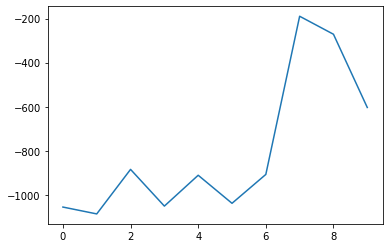

In [15]:
plt.plot(test_results['reward'])

###  Transitions from the Traj buffer, learning after episode

In [16]:
memory_trans = TransitionMemoryBuffer(scheme=scheme, max_size=int(1e6), min_size_to_sample=2000, 
                                      sample_during_episode=True)


memory_traj = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6/200), min_size_to_sample=10, 
                                     use_transitions=False, sample_during_episode=False)

memory_traj_trans = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6/200), min_size_to_sample=10, 
                                          use_transitions=True, sample_during_episode=False)



lstm_dims_list = []
hidden_dims_list = [64, 64]

agent = TD3Agent(observation_dim, action_dim, max_action_value, lstm_dims_list, hidden_dims_list,
                 actor_lr=8e-4, critic_lr=8e-4,  discount=0.99, tau=0.05,
                 policy_noise=0.2, noise_clip=0.5, policy_update_freq=2)

runner = Runner(env, memory_traj_trans, agent)

batch_size =  512

In [17]:
n_eps = 2001
print_each = 50
test_each = 50
n_test_episodes = 10

keys_to_print = ['reward']
train_results = defaultdict(list)
test_results = defaultdict(list)

for ep in range(1, n_eps):
    #print('            EP%d' % ep)
    episode_results = runner.run(train=True, save_to_memory=True, train_bath_size=batch_size)
    for key, val in episode_results.items():
        train_results[key].append(val)
    
    if ep % print_each == 0:
        print('Training episode %d    ' % ep)
        for key in keys_to_print:
            print('    %s=%.2f' % (key, np.mean(train_results[key][-print_each:])))
        print()
        
    if ep % test_each == 0:
        current_test_results = defaultdict(list)
        for test_ep in range(n_test_episodes):
            episode_results = runner.run(train=False, save_to_memory=False)
            for key, val in episode_results.items():
                current_test_results[key].append(val)
        current_test_results = {key: np.mean(val) for key, val in current_test_results.items()}
        for key, val in current_test_results.items():
            test_results[key].append(val)
            
        print('Test run after episode %d:' % ep)
        for key in keys_to_print:
            print('    %s=%.2f' % (key, current_test_results[key]))
        print()
        

Training episode 50    
    reward=-1407.28

Test run after episode 50:
    reward=-1684.79

Training episode 100    
    reward=-1663.41

Test run after episode 100:
    reward=-1591.06

Training episode 150    
    reward=-1552.23

Test run after episode 150:
    reward=-1377.90

Training episode 200    
    reward=-1378.12

Test run after episode 200:
    reward=-1288.64

Training episode 250    
    reward=-1271.07

Test run after episode 250:
    reward=-1296.31

Training episode 300    
    reward=-1235.50

Test run after episode 300:
    reward=-1307.48

Training episode 350    
    reward=-1236.45

Test run after episode 350:
    reward=-1142.11

Training episode 400    
    reward=-1230.18

Test run after episode 400:
    reward=-1196.03

Training episode 450    
    reward=-1251.55

Test run after episode 450:
    reward=-1242.51

Training episode 500    
    reward=-1313.54

Test run after episode 500:
    reward=-1323.67

Training episode 550    
    reward=-1333.49

Test r

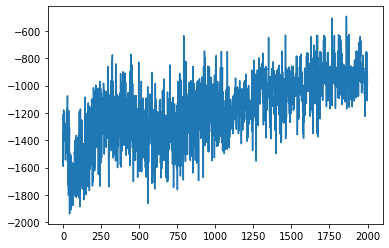

In [18]:
plt.plot(train_results['reward'])

###  Trajectories from the Traj buffer, learning after episode

In [19]:
memory_trans = TransitionMemoryBuffer(scheme=scheme, max_size=int(1e6), min_size_to_sample=2000, 
                                      sample_during_episode=True)


memory_traj = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6/200), min_size_to_sample=10, 
                                     use_transitions=False, sample_during_episode=True)

memory_traj_trans = TrajectoryMemoryBuffer(scheme=scheme, max_size=int(1e6/200), min_size_to_sample=10, 
                                          use_transitions=True, sample_during_episode=False)

lstm_dims_list = [64]
hidden_dims_list = [64]

agent = TD3Agent(observation_dim, action_dim, max_action_value, lstm_dims_list, hidden_dims_list,
                 actor_lr=8e-4, critic_lr=8e-4,  discount=0.99, tau=0.05,
                 policy_noise=0.2, noise_clip=0.5, policy_update_freq=2)

runner = Runner(env, memory_traj, agent)

batch_size =  1

In [ ]:
n_eps = 2001
print_each = 5
test_each = 50
n_test_episodes = 10

keys_to_print = ['reward']
train_results = defaultdict(list)
test_results = defaultdict(list)

for ep in range(1, n_eps):
    #print('            EP%d' % ep)
    episode_results = runner.run(train=True, save_to_memory=True, train_bath_size=batch_size)
    for key, val in episode_results.items():
        train_results[key].append(val)
    
    if ep % print_each == 0:
        print('Training episode %d    ' % ep)
        for key in keys_to_print:
            print('    %s=%.2f' % (key, np.mean(train_results[key][-print_each:])))
        print()
        
    if ep % test_each == 0:
        current_test_results = defaultdict(list)
        for test_ep in range(n_test_episodes):
            episode_results = runner.run(train=False, save_to_memory=False)
            for key, val in episode_results.items():
                current_test_results[key].append(val)
        current_test_results = {key: np.mean(val) for key, val in current_test_results.items()}
        for key, val in current_test_results.items():
            test_results[key].append(val)
            
        print('Test run after episode %d:' % ep)
        for key in keys_to_print:
            print('    %s=%.2f' % (key, current_test_results[key]))
        print()
        

In [ ]:
plt.plot(train_results['reward'])

In [ ]:
plt.plot(train_results['reward'])